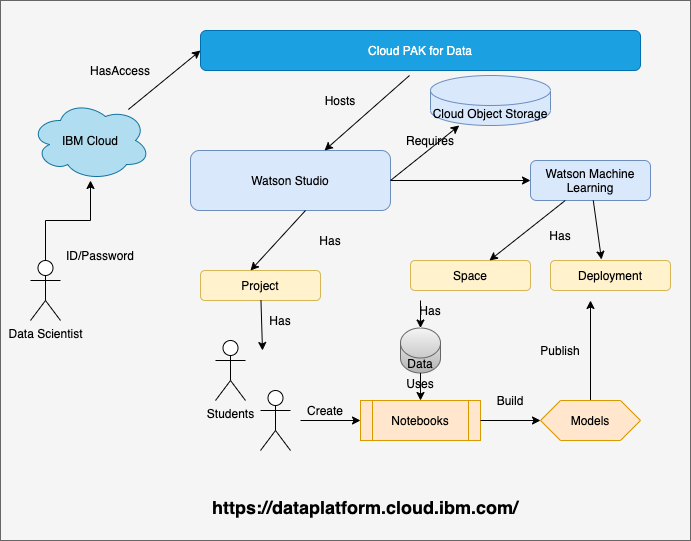


# Use scikit-learn to recognize hand-written digits with `ibm-watson-machine-learning`

This notebook contains steps and code to demonstrate how to persist and deploy locally trained scikit-learn model in Watson Machine Learning Service. This notebook contains steps and code to work with [ibm-watson-machine-learning](https://pypi.python.org/pypi/ibm-watson-machine-learning) library available in PyPI repository. This notebook introduces commands for getting model and training data, persisting model, deploying model, scoring it, updating the model and redeploying it.

Some familiarity with Python is helpful. This notebook uses Python 3.6 with the ibm-watson-machine-learning package.

## Learning goals

The learning goals of this notebook are:

-  Train sklearn model.
-  Persist trained model in Watson Machine Learning repository.
-  Deploy model for online scoring using client library.
-  Score sample records using client library.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Explore data and create scikit-learn model](#train)
3.	[Persist externally created scikit model](#persistence)
4.	[Deploy and score in a Cloud](#scoring)
5.  [Clean up](#cleanup)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = 'GLNVZdOJg6VSvTT_yXbZMk667X2Vl9BKiFBilKxiYHyY'
location = 'us-south'


#location = 'us-south'

In [2]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [3]:
!pip install -U ibm-watson-machine-learning

Requirement already up-to-date: ibm-watson-machine-learning in /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages (1.0.45)


In [4]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [5]:
client.spaces.list(limit=10)

------------------------------------  -----------  ------------------------
ID                                    NAME         CREATED
5e164018-902f-4eb7-aa37-d9d8ef1a5ea3  HW: 2/3      2021-02-04T06:05:27.783Z
b3af0ef0-8dd7-42bc-9c5f-ebe91270eb05  Module-2-HW  2021-01-26T20:45:45.770Z
------------------------------------  -----------  ------------------------


In [6]:
space_id = '5e164018-902f-4eb7-aa37-d9d8ef1a5ea3'


You can use `list` method to print all existing spaces.

In [7]:
client.spaces.list(limit=10)

------------------------------------  -----------  ------------------------
ID                                    NAME         CREATED
5e164018-902f-4eb7-aa37-d9d8ef1a5ea3  HW: 2/3      2021-02-04T06:05:27.783Z
b3af0ef0-8dd7-42bc-9c5f-ebe91270eb05  Module-2-HW  2021-01-26T20:45:45.770Z
------------------------------------  -----------  ------------------------


To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [8]:
client.set.default_space(space_id)

'SUCCESS'

<a id="train"></a>
## 2. Explore data and create scikit-learn model
In this section, you will prepare and train handwritten digits model using scikit-learn library.

### 2.1 Explore data

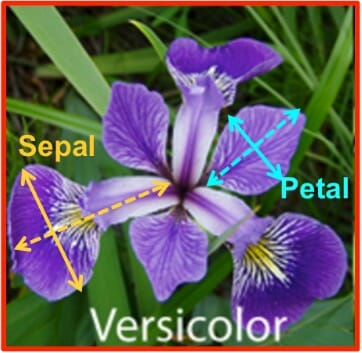

As a first step, you will load the data from scikit-learn sample datasets and perform a basic exploration.

([], <a list of 0 Text major ticklabel objects>)

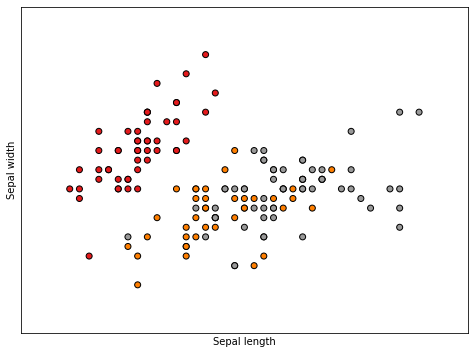

In [9]:
import sklearn
from sklearn import datasets

import matplotlib.pyplot as plt

# import some data to play with
iris = datasets.load_iris()
XX = iris.data[:, :2]  # we only take the first two features.
yy = iris.target

x_min, x_max = XX[:, 0].min() - .5, XX[:, 0].max() + .5
y_min, y_max = XX[:, 1].min() - .5, XX[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(XX[:, 0], XX[:, 1], c=yy, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

Loaded toy dataset consists of 8x8 pixels images of hand-written digits.

Let's display first digit data and label using **data** and **target**.

In [10]:
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [11]:
#print(iris.data)
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [12]:
#iris.target
print('[predicted values] target  names: ' , iris.target_names)
print('[input values]     feature names: ', iris.feature_names)

[predicted values] target  names:  ['setosa' 'versicolor' 'virginica']
[input values]     feature names:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In next step, you will count data examples.

In [13]:
print(iris.data.shape)

(150, 4)


### 2.2. Create a scikit-learn model

**Prepare data**

In [14]:
X = iris.data  # we take all 4 features.
y = iris.target

print(X.shape)

(150, 4)


**Create Helper function**

To evaluate model performance

In [15]:
def evaluateMetrics(predictions):
    # Evaluating Model's Performance
    # Takes predictions from Model and calculates metrics
    print('\n-------------------------------------------------------\n')
    print('Model accuracy: ' , metrics.accuracy_score(y_test, predictions))

    print('\nClassification report: \n' , metrics.classification_report(y_test, predictions))


    print('\nMean Absolute Error:     ', mean_absolute_error(y_test, predictions))
    print(  'Mean Squared Error:      ', mean_squared_error(y_test, predictions))
    print(  'Mean Root Squared Error: ', np.sqrt(mean_squared_error(y_test, predictions)))
    print('\n-------------------------------------------------------\n')

In ths step, you will import scikit-learn machine learning packages that will be needed in next cells.

In [16]:
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import svm
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

Divide the data into train and test for model fitting and evaluation.

In [17]:
# Splitting the Dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 101)

**Train model**

Now, you can train your **SVM model** by using the previously defined **train data**. You can check your model quality next, to evaluate the model, use test data.

In [18]:
# Instantiating  Model
svc_model = SVC()

# Training/Fitting the Model
svc_model.fit(X_train, y_train)

# Predict & Evaluate the Model
svc_predictions = svc_model.predict(X_test)

evaluateMetrics(svc_predictions)

# make a prediction for an example of an out-of-sample observation
print(svc_model.predict( [[6, 3, 4, 2]]) )


-------------------------------------------------------

Model accuracy:  0.98

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.95      0.98        22
           2       0.93      1.00      0.96        13

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50


Mean Absolute Error:      0.02
Mean Squared Error:       0.02
Mean Root Squared Error:  0.1414213562373095

-------------------------------------------------------

[1]


Now, you can train your **Logistic Regresion**  model. You can check your model quality now. To evaluate the model, use test data

In [20]:
# Instantiating  Model
lr_model = LogisticRegression()

# Homework starts here

    # Training/Fitting the Model
lr_model.fit(X_train, y_train)

    # Predict & Evaluate the Model
lr_predictions = lr_model.predict(X_test)
    # Evaluate the model

evaluateMetrics(lr_predictions)

# Homeworks ends here

# make a prediction for an example of an out-of-sample observation
print(lr_model.predict( [[6, 3, 4, 2]]) )


-------------------------------------------------------

Model accuracy:  0.98

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.95      0.98        22
           2       0.93      1.00      0.96        13

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50


Mean Absolute Error:      0.02
Mean Squared Error:       0.02
Mean Root Squared Error:  0.1414213562373095

-------------------------------------------------------

[1]


Now, you can train your **Naive Bayes** model. You can check your model quality now. To evaluate the model, use test data

In [21]:
# Instantiating  Model
nb_model = MultinomialNB()

# Homework starts here

    # Training/Fitting the Model
nb_model.fit(X_train, y_train)

    # Predict & Evaluate the Model
nb_predictions = nb_model.predict(X_test)

    # Evaluate the model
    
evaluateMetrics(nb_predictions)

# Homeworks ends here

# make a prediction for an example of an out-of-sample observation
print(nb_model.predict( [[6, 3, 4, 2]]) )


-------------------------------------------------------

Model accuracy:  0.56

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.00      0.00      0.00        22
           2       0.37      1.00      0.54        13

    accuracy                           0.56        50
   macro avg       0.46      0.67      0.51        50
weighted avg       0.40      0.56      0.44        50


Mean Absolute Error:      0.44
Mean Squared Error:       0.44
Mean Root Squared Error:  0.6633249580710799

-------------------------------------------------------

[2]


Now, you can train your **K-Neighbors model**. You can check your model quality now. To evaluate the model, use test data

In [22]:
# Instantiating  Model
knn_model = KNeighborsClassifier(n_neighbors=12)

# Homework starts here

    # Training/Fitting the Model
knn_model.fit(X_train, y_train)


    # Predict & Evaluate the Model
knn_predictions = knn_model.predict(X_test)

    # Evaluate the model
evaluateMetrics(knn_predictions)


# Homeworks ends here

# make a prediction for an example of an out-of-sample observation
print(knn_model.predict( [[6, 3, 4, 2]]) )


-------------------------------------------------------

Model accuracy:  0.96

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.95      0.95      0.95        22
           2       0.92      0.92      0.92        13

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50


Mean Absolute Error:      0.04
Mean Squared Error:       0.04
Mean Root Squared Error:  0.2

-------------------------------------------------------

[1]


Now, you can also train your **K-Neighbors** with n=20

In [23]:
# Instantiating  Model
knn_model = KNeighborsClassifier(n_neighbors=20)

# Homework starts here
    # Training/Fitting the Model
knn_model.fit(X_train, y_train)


    # Predict & Evaluate the Model
knn_predictions = knn_model.predict(X_test)

    # Evaluate the model
evaluateMetrics(knn_predictions)

# Homeworks ends here

# make a prediction for an example of an out-of-sample observation
print(knn_model.predict( [[6, 3, 4, 2]]) )


-------------------------------------------------------

Model accuracy:  0.94

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.91      0.95      0.93        22
           2       0.92      0.85      0.88        13

    accuracy                           0.94        50
   macro avg       0.94      0.93      0.94        50
weighted avg       0.94      0.94      0.94        50


Mean Absolute Error:      0.06
Mean Squared Error:       0.06
Mean Root Squared Error:  0.2449489742783178

-------------------------------------------------------

[1]


You can tune your model now to achieve better accuracy. For simplicity of this example tuning section is omitted.

<a id="persistence"></a>
## 3. Persist locally created scikit-learn model

In this section, you will learn how to store your model in Watson Machine Learning repository by using the IBM Watson Machine Learning SDK.

### 3.1: Publish model

#### Publish model in Watson Machine Learning repository on Cloud.

Define model name, autor name and email.

In [24]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

In [26]:
metadata = {
            client.repository.ModelMetaNames.NAME: 'Scikit model',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    # Homework starts here
    model=knn_model,
    # Homework ends here
    meta_props=metadata,
    training_data=X_train,
    training_target=iris.target_names)

### 3.2: Get model details

In [27]:
import json

published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "label_column": "l1",
    "software_spec": {
      "id": "e4429883-c883-42b6-87a8-f419d64088cd",
      "name": "default_py3.7"
    },
    "training_data_references": [
      {
        "connection": {
          "access_key_id": "not_applicable",
          "endpoint_url": "not_applicable",
          "secret_access_key": "not_applicable"
        },
        "id": "1",
        "location": {},
        "schema": {
          "fields": [
            {
              "name": "f0",
              "type": "float"
            },
            {
              "name": "f1",
              "type": "float"
            },
            {
              "name": "f2",
              "type": "float"
            },
            {
              "name": "f3",
              "type": "float"
            }
          ],
          "id": "1",
          "type": "ndarray"
        },
        "type": "s3"
      }
    ],
    "type": "scikit-learn_0.23"
  },
  "metadata": {
    "created_at": "2021-02-04T06:22:00

### 3.3 Get all models

In [28]:
models_details = client.repository.list_models()

------------------------------------  ------------  ------------------------  -----------------
ID                                    NAME          CREATED                   TYPE
94a5b4f9-7c2b-47d5-932d-568bf820eed0  Scikit model  2021-02-04T06:22:00.002Z  scikit-learn_0.23
------------------------------------  ------------  ------------------------  -----------------


<a id="scoring"></a>
## 4. Deploy and score in a Cloud

In this section you will learn how to create online scoring and to score a new data record by using the IBM Watson Machine Learning SDK.

### 4.1: Create model deployment

#### Create online deployment for published model

In [29]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of scikit model Iris Dataset",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '94a5b4f9-7c2b-47d5-932d-568bf820eed0' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f21f00b1-bf86-4843-ab5f-6bb92df52de8'
------------------------------------------------------------------------------------------------




**Note**: Here we use deployment url saved in published_model object. In next section, we show how to retrive deployment url from Watson Machine Learning instance.

In [30]:
deployment_uid = client.deployments.get_uid(created_deployment)

Now you can print an online scoring endpoint. 

In [31]:
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/ml/v4/deployments/f21f00b1-bf86-4843-ab5f-6bb92df52de8/predictions


You can also list existing deployments.

In [32]:
client.deployments.list()

------------------------------------  ---------------------------------------  -----  ------------------------
GUID                                  NAME                                     STATE  CREATED
f21f00b1-bf86-4843-ab5f-6bb92df52de8  Deployment of scikit model Iris Dataset  ready  2021-02-04T06:22:57.951Z
------------------------------------  ---------------------------------------  -----  ------------------------


### 4.2: Get deployment details

In [33]:
client.deployments.get_details(deployment_uid)

{'entity': {'asset': {'id': '94a5b4f9-7c2b-47d5-932d-568bf820eed0'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'Not_Applicable', 'name': 'S', 'num_nodes': 1},
  'name': 'Deployment of scikit model Iris Dataset',
  'online': {},
  'space_id': '5e164018-902f-4eb7-aa37-d9d8ef1a5ea3',
  'status': {'online_url': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/f21f00b1-bf86-4843-ab5f-6bb92df52de8/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2021-02-04T06:22:57.951Z',
  'id': 'f21f00b1-bf86-4843-ab5f-6bb92df52de8',
  'modified_at': '2021-02-04T06:22:57.951Z',
  'name': 'Deployment of scikit model Iris Dataset',
  'owner': 'IBMid-55000AE70K',
  'space_id': '5e164018-902f-4eb7-aa37-d9d8ef1a5ea3'}}

### 4.3: Score

You can use the following method to do test scoring request against deployed model.

**Action**: Prepare scoring payload with records to score.

In [34]:
samples_count = len(iris.data)
print("Number of samples: " + str(samples_count))

Number of samples: 150


In [35]:


score_data = iris.data[int(0.9*samples_count): ]


print("Number of scoring records : " + str(len(score_data)))

Number of scoring records : 15


In [36]:
score_0 = list(score_data[0])
score_1 = list(score_data[1])

In [37]:

print(score_0)

[7.7, 3.0, 6.1, 2.3]


In [38]:
scoring_payload = {"input_data": [{"values": [score_0, score_1]}]}

Use ``client.deployments.score()`` method to run scoring.

In [39]:
predictions = client.deployments.score(deployment_uid, scoring_payload)

In [78]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "fields": [
        "prediction"
      ],
      "values": [
        [
          2
        ],
        [
          2
        ]
      ]
    }
  ]
}


<a id="cleanup"></a>
## 5. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 6. Summary and next steps

 You successfully completed this notebook! You learned how to use scikit-learn machine learning as well as Watson Machine Learning for model creation and deployment. Check out our _[Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=analytics?pos=2)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Daniel Ryszka**, Software Engineer

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.